<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>

<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>

<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center><br>
TÍTULO: Modelos Preditivos Utilizando Séries Temporais da Bolsa de Valores<br>
<br>
ALUNO: Roberta Fonseca Santos de Paula</h3>

<p>Este notebook é referente ao Trabalho de Conclusão de Curso em Ciência de Dados e Big Data. Para o desenvolvimento deste trabalho foi utilizada a API Yahoo Finance para obtenção dos datasets das ações analisadas.</p>

<h3>CARREGAMENTO E TRATAMENTO DOS DADOS:</h3>

In [7]:
%matplotlib inline

#Bibliotecas básicas do python
import numpy as np 
import seaborn as sns
import pandas as pd
from pandas import DataFrame
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime
import math

#Bibliotecas para utilização do Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#Bibliotecas para utilização do ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
import pmdarima as pm

#Bibliotecas para utilização do Keras
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'fbprophet'

<p>As ações analisadas são: Banco do Brasil (BBAS3.SA), Banco Bradesco (BBDC4.SA) e Banco Itaú (ITUB4.SA). Sendo que os modelos de Machine Learning utilizados são para previsão do ano de 2020 das ações mensionadas. Para os modelos de previsão, os dados de treinamento utilizam o início do período de 2015 até o fim de 2019.</p>

In [5]:
#Escolha do período a ser utilizado no treinamento:

train_start_date = '2015-01-01'
train_end_date = '2019-12-31'

#Escolha do período a ser utilizado nos testes:

test_start_date = '2020-01-01'
test_end_date = '2020-12-31'

In [3]:
#Escolha das ações a serem analisadas:

tickers = ['BBAS3.SA', 'BBDC4.SA', 'ITUB4.SA']

In [4]:
# Utilização do pandas_datareader para carregar os dados de treinamento do Yahoo Finance:

train_dataset_bbas3 = data.DataReader(tickers[0], 'yahoo', train_start_date, train_end_date)
train_dataset_bbdc4 = data.DataReader(tickers[1], 'yahoo', train_start_date, train_end_date)
train_dataset_itub4 = data.DataReader(tickers[2], 'yahoo', train_start_date, train_end_date)

NameError: name 'tickers' is not defined

In [5]:
# Utilização do pandas_datareader para carregar os dados de teste do Yahoo Finance:

test_dataset_bbas3 = data.DataReader(tickers[0], 'yahoo', test_start_date, test_end_date)
test_dataset_bbdc4 = data.DataReader(tickers[1], 'yahoo', test_start_date, test_end_date)
test_dataset_itub4 = data.DataReader(tickers[2], 'yahoo', test_start_date, test_end_date)

<p>Os datasets contém 7 colunas cada, sendo o índice a coluna <b>Date</b>:
<ul>
  <li><b>Date:</b> Data da negociação</li>
  <li><b>High:</b> Maior preço da ação no dia</li>
  <li><b>Low:</b> Menor preço da ação no dia</li>
  <li><b>Open:</b> Preço de abertura da ação no dia</li>
  <li><b>Close:</b> Preço de fechamento da ação no dia</li>
  <li><b>Volume:</b> Volume total negociado no dia</li>
  <li><b>Adj Close:</b> Valor ajustado da ação no dia. Considera desconto de dividentos, splits, inplits, etc</li>
</ul>

Neste trabalho, a coluna utilizada nos modelos de predição é o preço de fechamento (Close).</p>

<h3>ANÁLISE EXPLORATÓRIA DOS DATASETS:</h3>
<h3>Ação BBAS3.SA</h3>


In [1]:
# Exibe as primeiras linhas do dataset da BBAS3:

train_dataset_bbas3.head()

NameError: name 'train_dataset_bbas3' is not defined

In [7]:
# Descrição estatística do conjunto de dados do Banco do Brasil:

train_dataset_bbas3.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1242.000000,1242.000000,1242.000000,1242.000000,1.242000e+03,1242.000000
mean,14.845668,14.310250,14.589203,14.561699,5.329012e+07,13.479213
std,5.038095,4.904037,4.976392,4.965847,3.464287e+07,4.629485
min,4.270000,4.120000,4.200000,4.200000,0.000000e+00,3.896639
25%,10.772500,10.210000,10.510000,10.510000,3.543018e+07,9.750875
50%,14.690000,14.195000,14.520000,14.440000,4.745220e+07,13.243935
75%,18.010000,17.332500,17.687500,17.677500,6.520258e+07,16.400676
max,28.330000,27.410000,28.260000,28.160000,6.989506e+08,26.243767


In [8]:
# Verifica se a PETR4 tem algum valor nulo
train_dataset_petr4.isnull().sum() 

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Distribuição do Preço de Fechamento da PETR4')

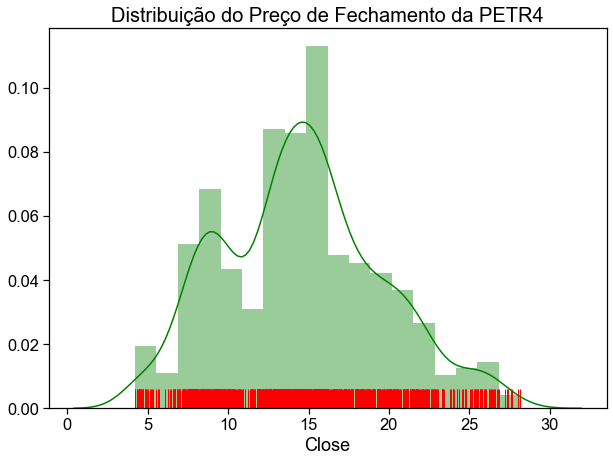

In [9]:
#Plota um histograma da distribuição da PETR4 utilizando as datas de fechamento do dia
plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(train_dataset_petr4['Close'], color= 'red')
sns.distplot(train_dataset_petr4['Close'], color= 'green')
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento da PETR4')

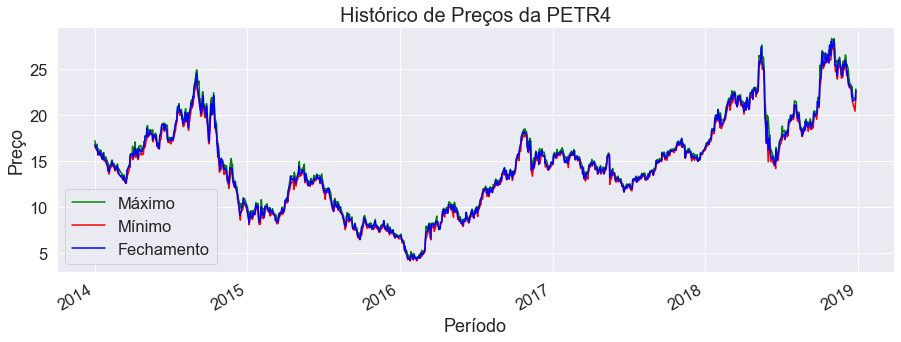

In [10]:
#Plotagem da série histórica
plt.figure(figsize=(15,5))
train_dataset_petr4['High'].plot(label = 'Máximo', color = 'green')
train_dataset_petr4['Low'].plot(label = 'Mínimo', color = 'red')
train_dataset_petr4['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Preço')
plt.xlabel('Período')
plt.title('Histórico de Preços da PETR4')
plt.legend();

Text(0.5, 1.0, 'Variação de preço diário da PETR4')

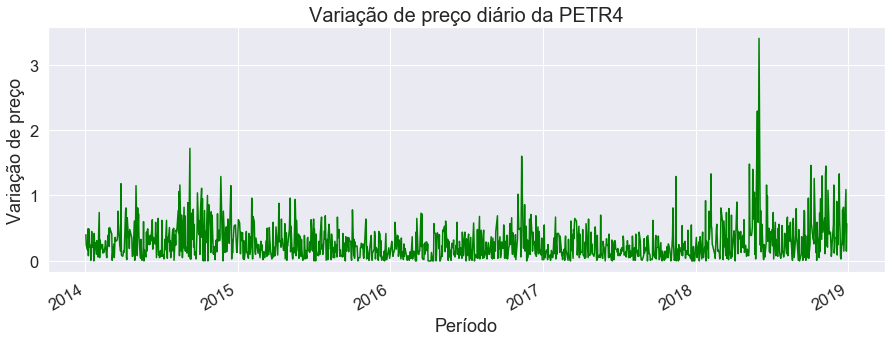

In [11]:
#Plotagem da variação de preço diária Valor absoluto(preço de fechamento - preço de abertura)
variation_petr4 = abs(train_dataset_petr4['Close'] - train_dataset_petr4['Open'])
plt.figure(figsize=(15,5))
variation_petr4.plot(label = 'Variação de preço', color = 'green')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário da PETR4')

In [12]:
#Retorna a data com a maior variação entre o preço de abertura e fechamento
max_variation_petr4 = variation_petr4.values.argmax()
max_value_petr4 = variation_petr4.values[max_variation_petr4,]
variation_petr4[variation_petr4.values == max_value_petr4]

Date
2018-06-01    3.4
dtype: float64

Text(0.5, 1.0, 'Volume negociado da PETR4')

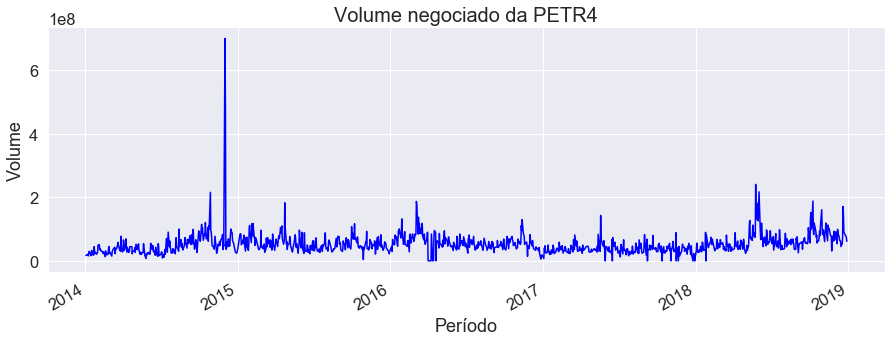

In [13]:
#Plotagem do volume negociado no período
plt.figure(figsize=(15,5))
train_dataset_petr4['Volume'].plot(label = 'Volume', color = 'blue')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado da PETR4')

In [14]:
#Retorna a data com o maior volume de negociação 
max_volume = train_dataset_petr4['Volume'].argmax()
train_dataset_petr4.iloc[max_volume,:]

High         1.254000e+01
Low          1.221000e+01
Open         1.245000e+01
Close        1.232000e+01
Volume       6.989506e+08
Adj Close    1.143014e+01
Name: 2014-12-01 00:00:00, dtype: float64

<h3>Ação ITUB4</h3>

In [15]:
#Exibe as primeiras linhas dos dados da ITUB4
train_dataset_itub4.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,15.8978,15.6223,15.7976,15.7876,25333788.0,11.780559
2014-01-03,15.9179,15.6824,15.7776,15.7576,40048592.0,11.758177
2014-01-06,15.8778,15.6824,15.7175,15.7826,25543620.0,11.776832
2014-01-07,15.9429,15.6073,15.7676,15.6624,25317616.0,11.687140
2014-01-08,15.9078,15.7025,15.7025,15.9078,21595142.0,11.870248


In [16]:
#Descrição estatística do conjunto de dados da ITUB4
train_dataset_itub4.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1242.000000,1242.000000,1242.000000,1242.000000,1.242000e+03,1242.000000
mean,23.170940,22.597220,22.886952,22.890062,2.136467e+07,19.822613
std,5.772940,5.683730,5.734574,5.728302,1.086807e+07,6.386544
min,14.072700,13.824200,13.939400,13.981800,0.000000e+00,10.935873
25%,18.715475,18.181801,18.430300,18.422699,1.408901e+07,14.528733
50%,21.477400,20.972449,21.236500,21.220349,1.961033e+07,17.083119
75%,27.713350,27.176675,27.371650,27.386700,2.568126e+07,25.329652
max,36.830002,36.020000,36.799999,36.349998,1.049172e+08,34.260559


In [17]:
#Verifica se a ITUB4 tem algum valor nulo
train_dataset_itub4.isnull().sum() 

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Distribuição do Preço de Fechamento da ITUB4')

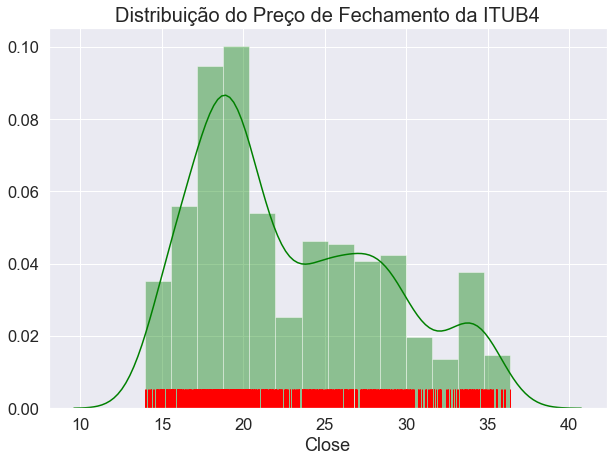

In [18]:
#Plota um histograma da distribuição da ITUB4 utilizando as datas de fechamento do dia
plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(train_dataset_itub4['Close'], color= 'red')
sns.distplot(train_dataset_itub4['Close'], color= 'green')
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento da ITUB4')

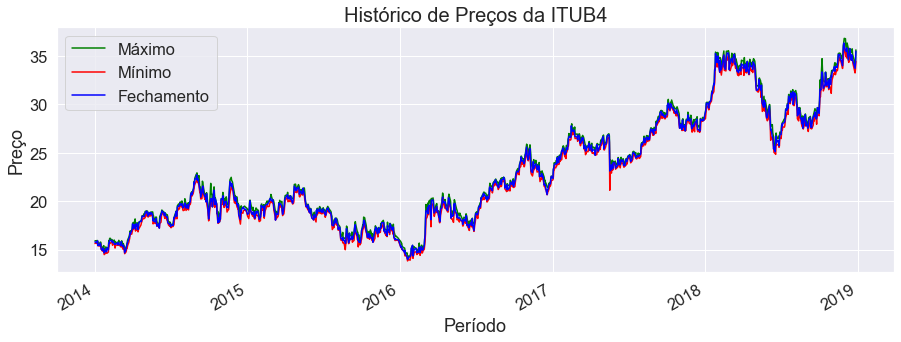

In [19]:
#Plotagem da série histórica
plt.figure(figsize=(15,5))
train_dataset_itub4['High'].plot(label = 'Máximo', color = 'green')
train_dataset_itub4['Low'].plot(label = 'Mínimo', color = 'red')
train_dataset_itub4['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Preço')
plt.xlabel('Período')
plt.title('Histórico de Preços da ITUB4')
plt.legend();

Text(0.5, 1.0, 'Variação de preço diário da ITUB4')

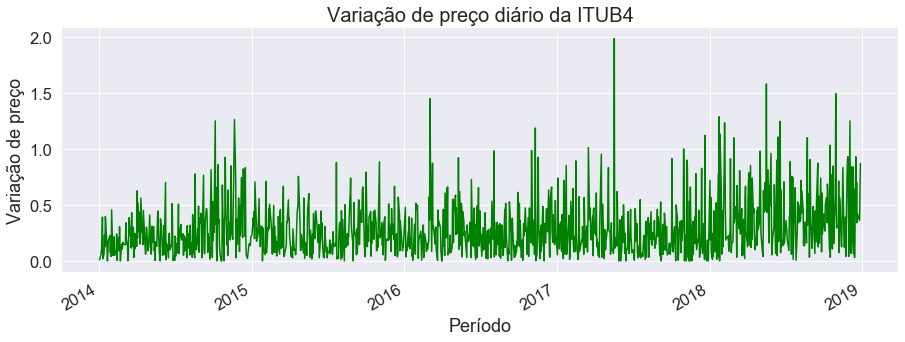

In [20]:
#Plotagem da variação de preço diária Valor absoluto(preço de fechamento - preço de abertura)
variation_itub4 = abs(train_dataset_itub4['Close'] - train_dataset_itub4['Open'])
plt.figure(figsize=(15,5))
variation_itub4.plot(label = 'Variação de preço', color = 'green')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário da ITUB4')

In [21]:
#Retorna a data com a maior variação entre o preço de abertura e fechamento
max_variation_itub4 = variation_itub4.values.argmax()
max_value_itub4 = variation_itub4.values[max_variation_itub4,]
variation_itub4[variation_itub4.values == max_value_itub4]

Date
2017-05-18    1.9867
dtype: float64

Text(0.5, 1.0, 'Volume negociado da ITUB4')

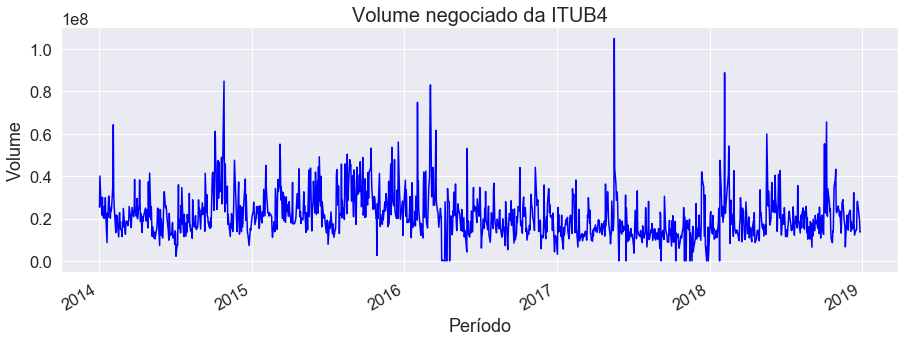

In [22]:
#Plotagem do volume negociado no período
plt.figure(figsize=(15,5))
train_dataset_itub4['Volume'].plot(label = 'Volume', color = 'blue')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado da ITUB4')

In [23]:
#Retorna a data com o maior volume de negociação 
max_volume = train_dataset_itub4['Volume'].argmax()
train_dataset_itub4.iloc[max_volume,:]

High         2.396000e+01
Low          2.113330e+01
Open         2.113330e+01
Close        2.312000e+01
Volume       1.049172e+08
Adj Close    2.098161e+01
Name: 2017-05-18 00:00:00, dtype: float64

<h3>Ação VALE3</h3>

In [24]:
#Exibe as primeiras linhas dos dados da VALE3
train_dataset_vale3.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,36.049999,34.570000,35.910000,34.810001,4395300.0,27.592508
2014-01-03,34.810001,33.810001,34.810001,34.060001,9207100.0,26.998014
2014-01-06,34.209999,33.389999,33.630001,34.090000,4527200.0,27.021793
2014-01-07,34.349998,33.119999,34.009998,33.250000,4352500.0,26.355953
2014-01-08,33.639999,33.270000,33.490002,33.480000,2697700.0,26.538271


In [25]:
#Descrição estatística do conjunto de dados da VALE3
train_dataset_vale3.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1242.000000,1242.000000,1242.000000,1242.000000,1.242000e+03,1242.000000
mean,29.784316,28.847955,29.319589,29.288841,9.732985e+06,26.385362
std,12.432266,12.238706,12.350820,12.349072,9.162519e+06,12.331075
min,9.060000,8.600000,8.750000,8.600000,0.000000e+00,7.664479
25%,19.300001,18.532501,18.910000,18.902500,4.686425e+06,16.531945
50%,28.955000,28.054999,28.490000,28.570001,6.900500e+06,24.171745
75%,34.437499,33.520000,34.000000,33.934999,1.305725e+07,30.516664
max,62.419998,60.480000,62.200001,62.200001,1.744043e+08,60.594360


In [26]:
#Verifica se a VALE3 tem algum valor nulo
train_dataset_vale3.isnull().sum() 

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Distribuição do Preço de Fechamento da VALE3')

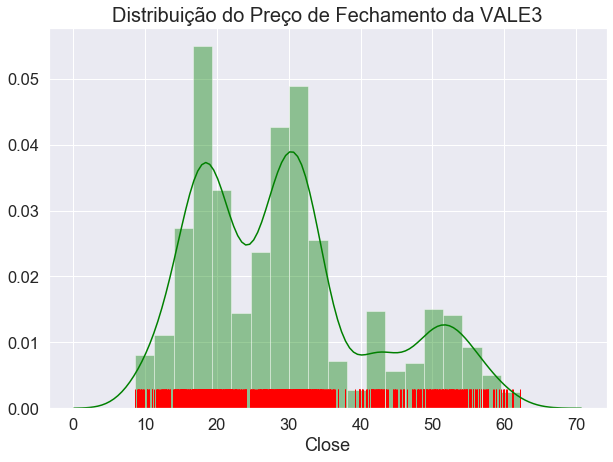

In [27]:
#Plota um histograma da distribuição da VALE3 utilizando as datas de fechamento do dia
plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(train_dataset_vale3['Close'], color= 'red')
sns.distplot(train_dataset_vale3['Close'], color= 'green')
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento da VALE3')

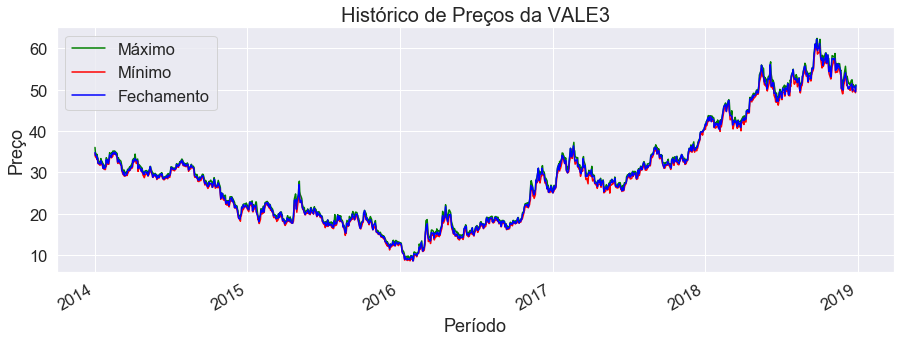

In [28]:
#Plotagem da série histórica
plt.figure(figsize=(15,5))
train_dataset_vale3['High'].plot(label = 'Máximo', color = 'green')
train_dataset_vale3['Low'].plot(label = 'Mínimo', color = 'red')
train_dataset_vale3['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Preço')
plt.xlabel('Período')
plt.title('Histórico de Preços da VALE3')
plt.legend();

Text(0.5, 1.0, 'Variação de preço diário da VALE3')

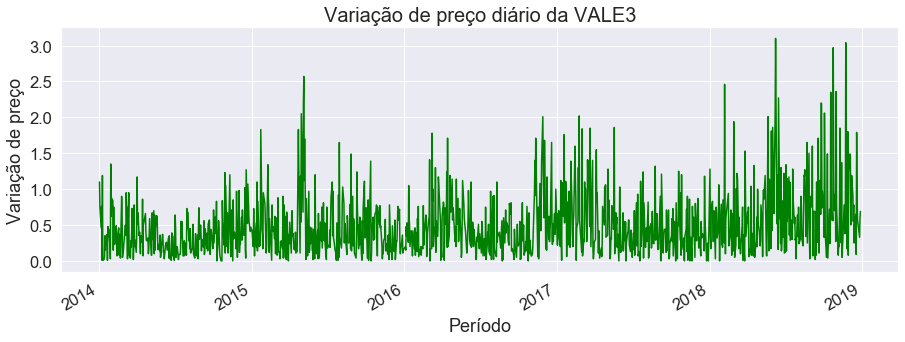

In [29]:
#Plotagem da variação de preço diária Valor absoluto(preço de fechamento - preço de abertura)
variation_vale3 = abs(train_dataset_vale3['Close'] - train_dataset_vale3['Open'])
plt.figure(figsize=(15,5))
variation_vale3.plot(label = 'Variação de preço', color = 'green')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário da VALE3')

In [30]:
#Retorna a data com a maior variação entre o preço de abertura e fechamento
max_variation_vale3 = variation_vale3.values.argmax()
max_value_vale3 = variation_vale3.values[max_variation_vale3,]
variation_vale3[variation_vale3.values == max_value_vale3]

Date
2018-06-08    3.100002
dtype: float64

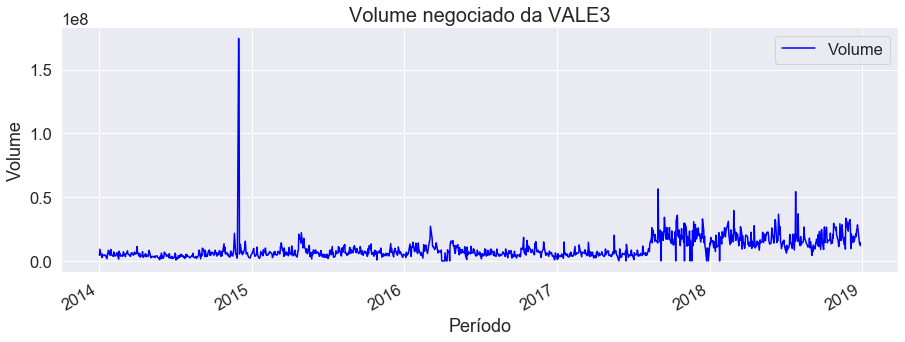

In [31]:
#Plotagem do volume negociado no período
plt.figure(figsize=(15,5))
train_dataset_vale3['Volume'].plot(label = 'Volume', color = 'blue')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado da VALE3')
plt.legend();

In [32]:
#Retorna a data com o maior volume de negociação 
max_volume = train_dataset_vale3['Volume'].argmax()
train_dataset_vale3.iloc[max_volume,:]

High         2.294000e+01
Low          2.205000e+01
Open         2.281000e+01
Close        2.213000e+01
Volume       1.744043e+08
Adj Close    1.871372e+01
Name: 2014-12-01 00:00:00, dtype: float64

<h3>Análise das ações em conjunto:</h3>
<h3>Comparativo de retorno utilizando o valor ajustado das ações</h3>

In [33]:
#Extrai os preços ajustados do fechamento de todas as ações e transforma em um único dataset para tratamento em conjunto
train_dataset_adj_petr4 = train_dataset_petr4.loc[:, ['Adj Close']]
train_dataset_adj_petr4.rename(columns={'Adj Close': 'PETR4'}, inplace=True)
train_dataset_adj_itub4 = train_dataset_itub4.loc[:, ['Adj Close']]
train_dataset_adj_itub4.rename(columns={'Adj Close': 'ITUB4'}, inplace=True)
train_dataset_adj_vale3 = train_dataset_vale3.loc[:, ['Adj Close']]
train_dataset_adj_vale3.rename(columns={'Adj Close': 'VALE3'}, inplace=True)
train_dataset_adj = pd.concat([train_dataset_adj_petr4, train_dataset_adj_itub4, train_dataset_adj_vale3], axis=1)
train_dataset_adj.head()

,PETR4,ITUB4,VALE3
Date,,,
2014-01-02,14.574201,11.780559,27.592508
2014-01-03,14.356676,11.758177,26.998014
2014-01-06,14.461090,11.776832,27.021793
2014-01-07,14.060842,11.687140,26.355953
2014-01-08,14.086944,11.870248,26.538271


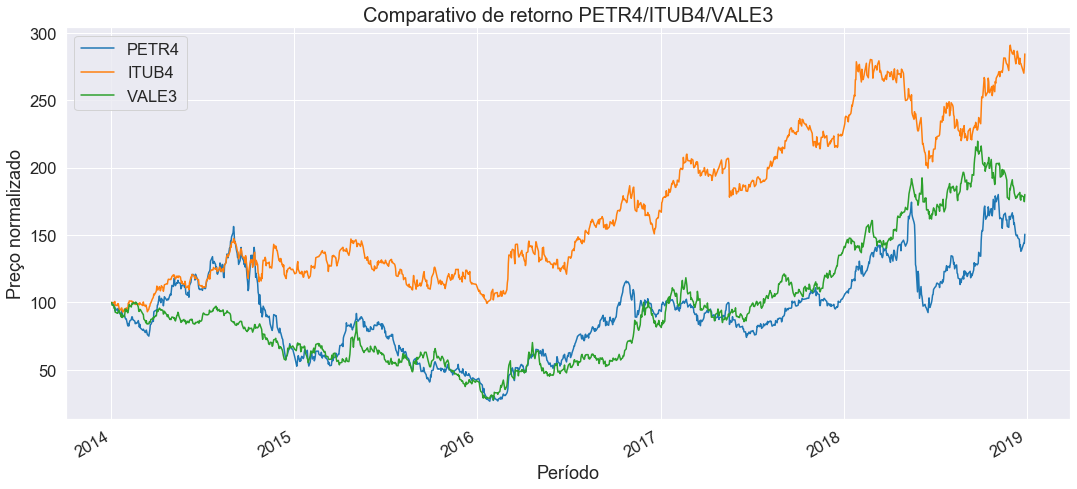

In [34]:
#Gráfico normalizado    
(train_dataset_adj/train_dataset_adj.iloc[0]*100).plot(figsize=(18,8))
plt.ylabel('Preço normalizado')
plt.xlabel('Período')
plt.title('Comparativo de retorno PETR4/ITUB4/VALE3')
plt.show()

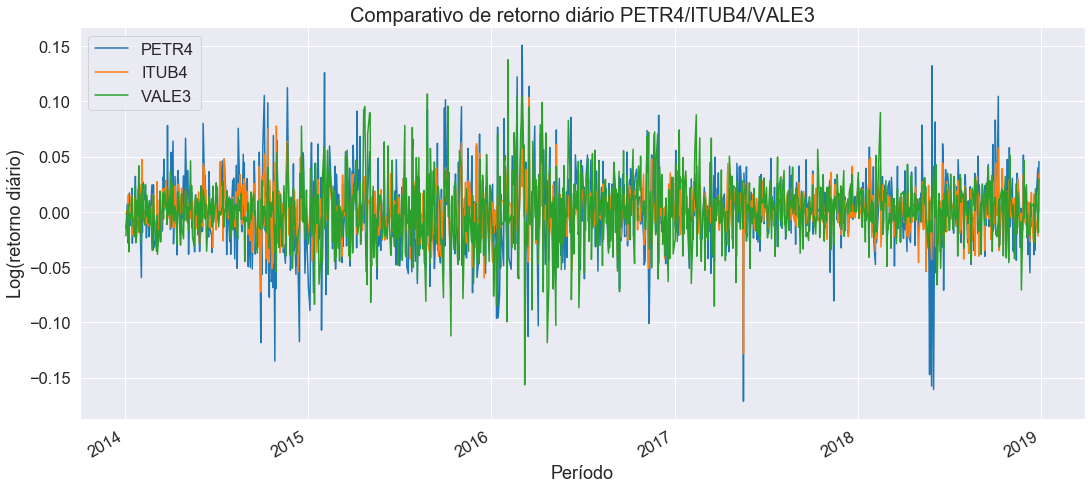

In [35]:
#Retorno diário
log_returns=np.log(train_dataset_adj/train_dataset_adj.shift(1))
log_returns.plot(figsize=(18,8))
plt.ylabel('Log(retorno diário)')
plt.xlabel('Período')
plt.title('Comparativo de retorno diário PETR4/ITUB4/VALE3')
plt.show()

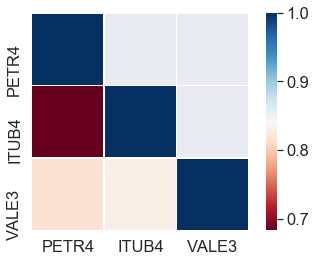

In [36]:
#Função para criação do mapa de correlação das ações
def plot_corr(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, 1)] = True
    sns.heatmap(corr, mask=mask, cmap='RdBu', square=True, linewidths=.5)
    
# Cálculo da correlação
corr = train_dataset_adj.corr() 
plot_corr(corr)

In [37]:
#Retorno médio diário
log_returns.mean()

PETR4    0.000330
ITUB4    0.000842
VALE3    0.000474
dtype: float64

In [38]:
#Percentual de retorno anualizado
(log_returns.mean()*250)*100 

PETR4     8.250485
ITUB4    21.049855
VALE3    11.847867
dtype: float64

In [39]:
#Risco
log_returns.std()

PETR4    0.034134
ITUB4    0.019859
VALE3    0.030058
dtype: float64

<h3>MODELOS PREDITIVOS PARA AÇÃO PETR4:</h3>
<p>O dataset de treinamento utiliza o período do início de 2014 até o fim de 2018 para prever o ano de 2019.</p>
<h3>Modelo preditivo com o Facebook Prophet</h3>

In [40]:
#Carregamento dos dados de treinamento e teste
train_petr4_prophet = train_dataset_petr4
test_petr4_prophet = test_dataset_petr4

In [41]:
#Remoção das colunas não utilizadas dos dados de treinamento e teste
train_petr4_prophet = train_petr4_prophet.drop(columns = ["Open", "High", "Low", "Volume", "Adj Close"])
test_petr4_prophet = test_petr4_prophet.drop(columns = ["Open", "High", "Low", "Volume", "Adj Close"])
train_petr4_prophet.head()

,Close
Date,
2014-01-02,16.750000
2014-01-03,16.500000
2014-01-06,16.620001
2014-01-07,16.160000
2014-01-08,16.190001


In [42]:
#Renomeia as colunas 'Close' para 'y' e 'Date' para 'ds' do conjunto de treinamento
train_petr4_prophet = pd.DataFrame({"ds": train_petr4_prophet.index, "y": train_petr4_prophet.Close})
train_petr4_prophet.reset_index(drop = True, inplace = True)
train_petr4_prophet.head()

,ds,y
0,2014-01-02,16.750000
1,2014-01-03,16.500000
2,2014-01-06,16.620001
3,2014-01-07,16.160000
4,2014-01-08,16.190001


In [43]:
#Renomeia as colunas 'Close' para 'y_test' e 'Date' para 'ds_test' do conjunto de teste
test_petr4_prophet = pd.DataFrame({"ds_test": test_petr4_prophet.index, "y_test": test_petr4_prophet.Close})
test_petr4_prophet.reset_index(drop = True, inplace = True)
test_petr4_prophet.head()

,ds_test,y_test
0,2019-01-02,24.059999
1,2019-01-03,24.650000
2,2019-01-04,24.719999
3,2019-01-07,25.110001
4,2019-01-08,24.959999


In [44]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(train_petr4_prophet)

Text(58.25, 0.5, 'Preço de fechamento')

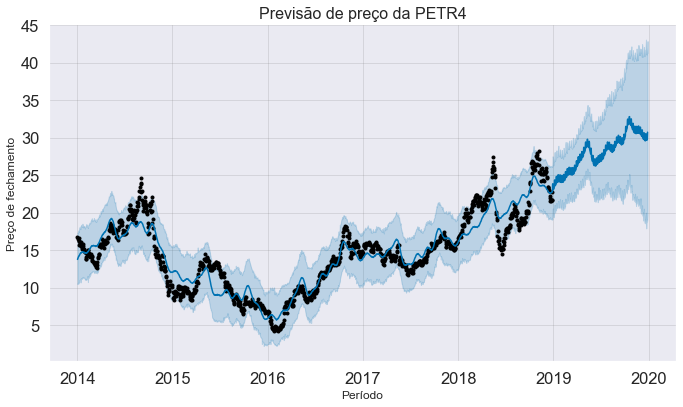

In [45]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=365, freq='D')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão de preço da PETR4", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Preço de fechamento", fontsize=12)

In [46]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > train_end_date]
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1245,2019-01-01,24.483497,19.649532,26.292412,24.483105,24.483497,-1.423182,-1.423182,-1.423182,-0.261578,-0.261578,-0.261578,-1.161605,-1.161605,-1.161605,0.0,0.0,0.0,23.060315
1246,2019-01-02,24.502695,19.354979,26.768553,24.499536,24.504186,-1.344562,-1.344562,-1.344562,-0.236740,-0.236740,-0.236740,-1.107822,-1.107822,-1.107822,0.0,0.0,0.0,23.158133
1247,2019-01-03,24.521892,19.661358,27.147567,24.516229,24.524557,-1.349517,-1.349517,-1.349517,-0.297537,-0.297537,-0.297537,-1.051979,-1.051979,-1.051979,0.0,0.0,0.0,23.172376
1248,2019-01-04,24.541090,19.948809,26.795718,24.531367,24.544255,-1.272424,-1.272424,-1.272424,-0.277571,-0.277571,-0.277571,-0.994853,-0.994853,-0.994853,0.0,0.0,0.0,23.268666
1249,2019-01-05,24.560288,20.672506,27.934629,24.545115,24.569544,-0.290092,-0.290092,-0.290092,0.647138,0.647138,0.647138,-0.937229,-0.937229,-0.937229,0.0,0.0,0.0,24.270196


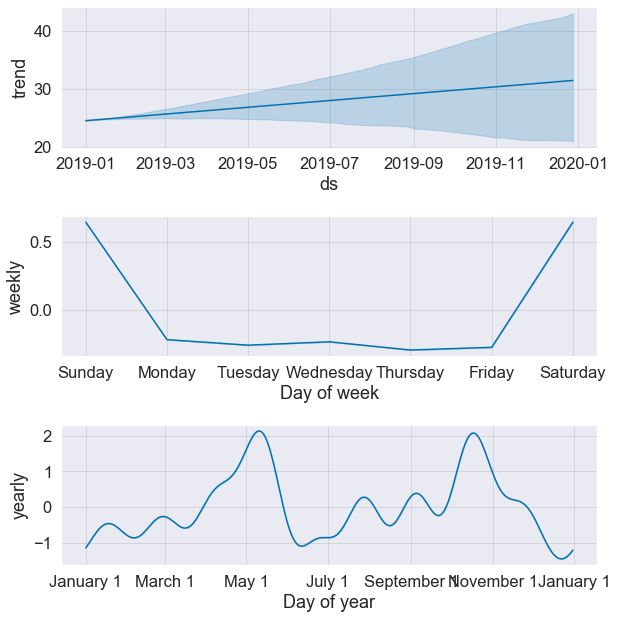

In [47]:
#Plotagem dos componententes da previsão
fig = prophet_model.plot_components(prophet_forecast)

In [48]:
#Exclusão dos fins de semana nos dados previstos
prophet_forecast = prophet_forecast[prophet_forecast['ds'].dt.dayofweek < 5]

#Exclusão dos feriados nos dados previstos
holidays = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(['2019-01-01','2019-01-25','2019-03-04','2019-03-05','2019-04-19','2019-05-01','2019-06-20','2019-07-09','2019-11-15','2019-11-20','2019-12-24','2019-12-25','2019-12-31']),
})

prophet_forecast = prophet_forecast[~prophet_forecast['ds'].isin(holidays['ds'])]
prophet_forecast = prophet_forecast.dropna()


In [49]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
test_petr4_prophet.set_index(test_petr4_prophet['ds_test'], inplace=True) 
train_petr4_prophet.set_index(train_petr4_prophet['ds'], inplace=True) 

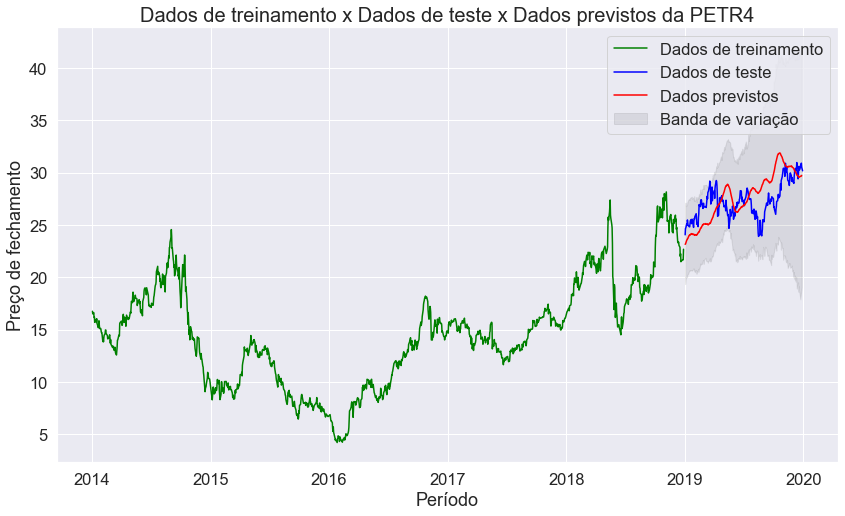

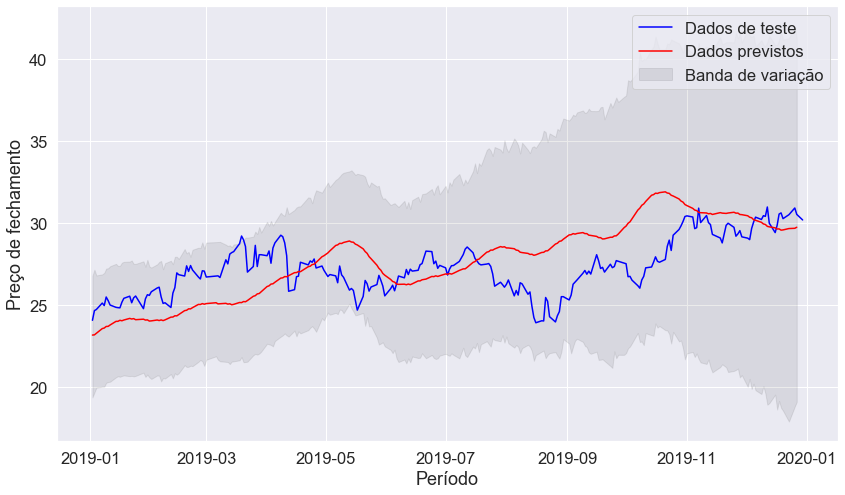

In [50]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = train_petr4_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da PETR4')
plt.plot(train_petr4_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(test_petr4_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Preço de fechamento")
plt.legend()
#plt.savefig('prophet1.pdf')
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(test_petr4_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Preço de fechamento")
plt.legend()
plt.grid(True)
#plt.savefig('prophet2.pdf')
plt.show()

In [51]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(test_petr4_prophet['y_test'],prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(test_petr4_prophet['y_test'],prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(test_petr4_prophet['y_test'],prophet_forecast['yhat'])))

MAE:  1.7772801725844554
MSE:  4.483243380602945
RMSE:  2.1173670868800585


<h3>Modelo preditivo com AUTO-ARIMA</h3>

In [52]:
#Carregamento dos dados
train_petr4_arima = train_dataset_petr4
train_petr4_arima = train_petr4_arima.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
test_petr4_arima = test_dataset_petr4
test_petr4_arima = test_petr4_arima.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
train_petr4_arima.head()

,Close
Date,
2014-01-02,16.750000
2014-01-03,16.500000
2014-01-06,16.620001
2014-01-07,16.160000
2014-01-08,16.190001


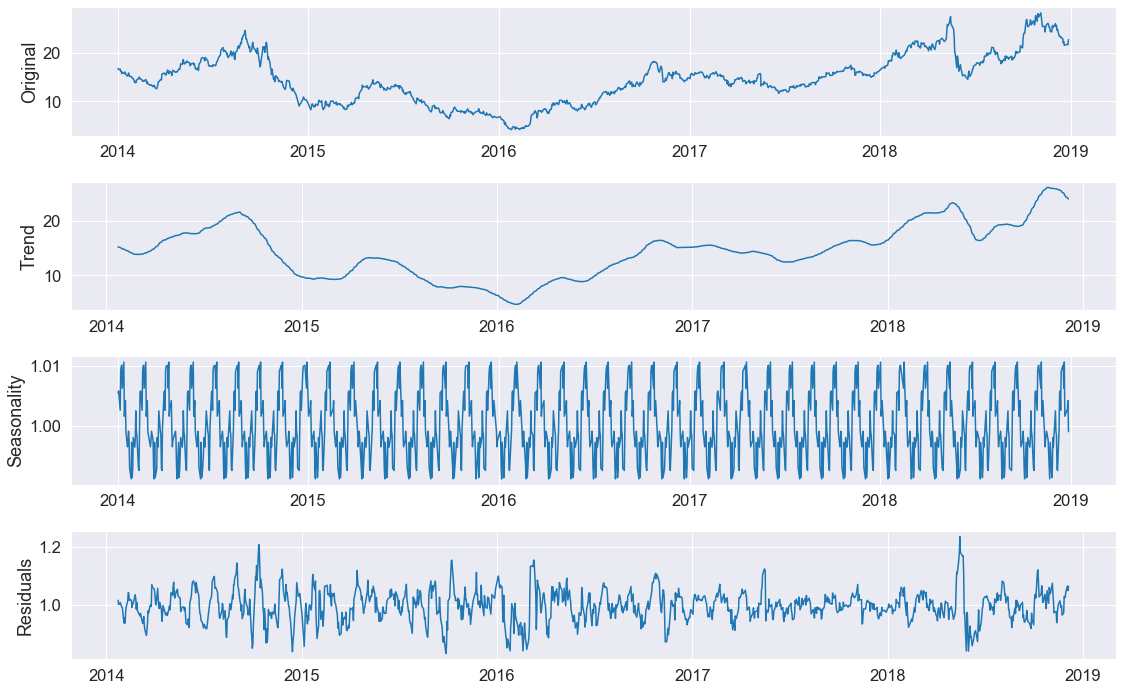

In [53]:
#Decomposição da série temporal
decomposition = seasonal_decompose(train_petr4_arima, model='multiplicative', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(16,10))
plt.subplot(411)
plt.plot(train_petr4_arima)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

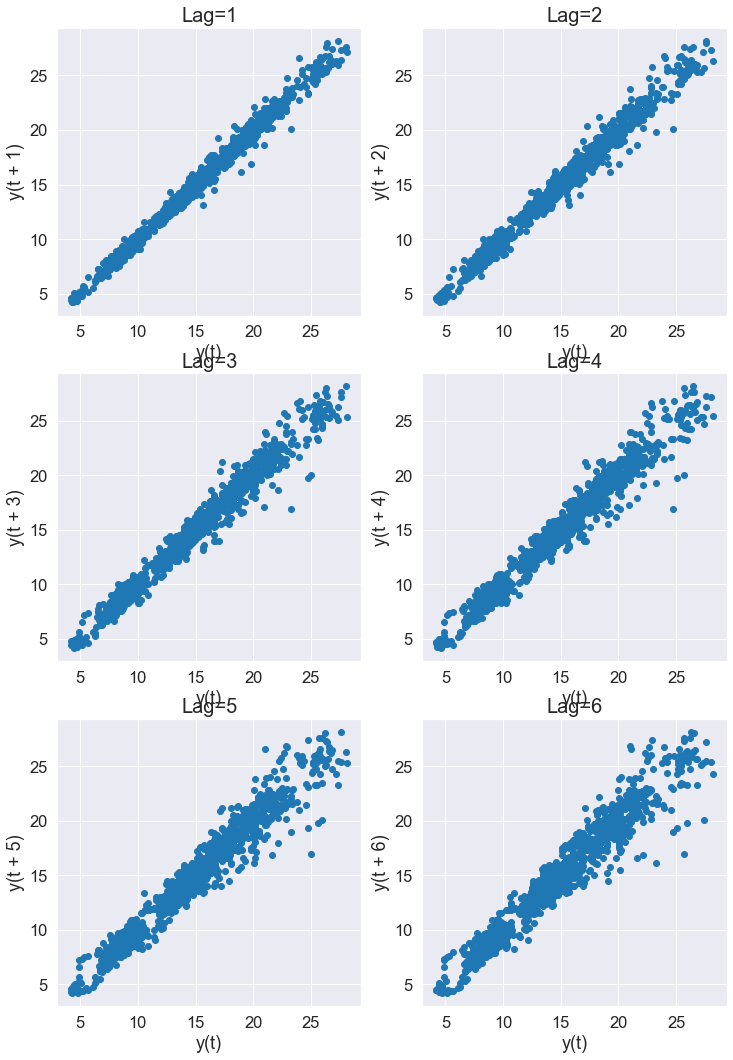

In [54]:
#Plotagem da Autocorrelação
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.title('Autocorrelação da ação PETR4')

# Coordenadas dos eixos para plotagem
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(train_petr4_arima["Close"], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

<p>Como a plotagem da autocorrelação parece bem linear, um modelo auto-regressivo poderia ser uma boa escolha. Mas ainda sim será utilizado o modelo auto-arima para identificação do melhor modelo de forma automática.</p>

In [55]:
#Função para verificar a estacionalidade 
def adf_test(y):
    print('Resultado do Teste Dickey-Fuller:')
    dftest = adfuller(y, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=['Teste','Valor p', 'Nº de lags', 'Nº de observações'])
    for key, value in dftest[4].items():
        dfoutput['Valor Crítico ({})'.format(key)] = value
    print(dfoutput)

adf_test(train_petr4_arima)

Resultado do Teste Dickey-Fuller:
Teste                    -1.508265
Valor p                   0.529419
Nº de lags               10.000000
Nº de observações      1231.000000
Valor Crítico (1%)       -3.435673
Valor Crítico (5%)       -2.863891
Valor Crítico (10%)      -2.568022
dtype: float64


<p>Com o resultado do teste Dickey-Fuller e pela análise do gráfico, conclui-se que a série não é estacionária. Com isso, pode-se tentar diferenciar a série para transformá-la em estacionária.</p>

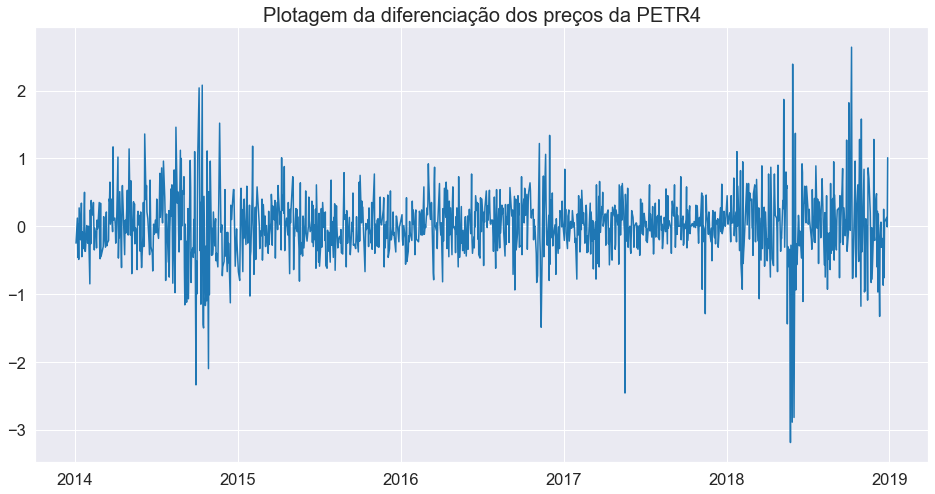

In [56]:
#Aplicação da diferenciação
train_petr4_arima_diff = train_petr4_arima - train_petr4_arima.shift()
train_petr4_arima_diff.dropna(inplace=True)

#Plotagem da diferenciação de primeira ordem da PETR4
plt.figure(figsize=(16,8))
plt.plot(train_petr4_arima_diff)
plt.title('Plotagem da diferenciação dos preços da PETR4')
plt.grid(True)

In [57]:
#Teste de Dickey-Fuller para série diferenciada
adf_test(train_petr4_arima_diff)

Resultado do Teste Dickey-Fuller:
Teste                 -1.099360e+01
Valor p                6.960303e-20
Nº de lags             9.000000e+00
Nº de observações      1.231000e+03
Valor Crítico (1%)    -3.435673e+00
Valor Crítico (5%)    -2.863891e+00
Valor Crítico (10%)   -2.568022e+00
dtype: float64


<p>Com o teste Dickey-Fuller e plotagem dos gráficos verifica-se que a série diferenciada é estacionária.</p>

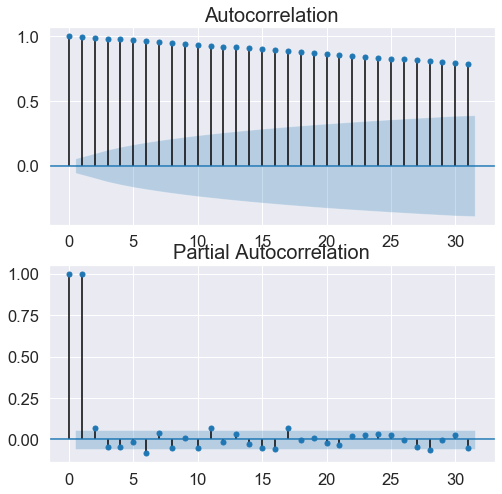

In [58]:
#Plotagem dos gráficos ACF e PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(train_petr4_arima, ax = ax1)
plot_pacf(train_petr4_arima, ax = ax2)
plt.show()

<p>Utilizando-se o fato da série ser estacionária para uma diferenciação de primeira ordem (d=1), pode-se utilizar a função auto_arima para determinar o melhor modelo que se adequa à série temporal estudada.</p>

<p><b>Principais parâmetros do modelo Auto-Arima:</b></p>
<p>p = número de time lags do modelo auto-regressivo (AR)</p>
<p>q = ordem do modelo de média-móvel (MA)</p>
<p>d = grau de diferenciação</p>
<p>P = refere-se ao termo auto-regressivo para a parte sazonal</p> 
<p>Q = refere-se ao termo de diferenciação para a parte sazonal</p>
<p>D = refere-se ao termo da média-móvel para a parte sazonal</p> 

In [59]:
#Definição do modelo
model = pm.auto_arima(train_petr4_arima['Close'], start_p=1, start_q=1,
                      #test='adf',       # usa o adftest para encontrar o melhor valor 'd'
                      max_p=3, max_q=3, # Máximo 'p' e 'q'
                      m=12,              # Frequência da série
                      d=1,           
                      stationary = False, #Estacionaridade
                      seasonal=True, #Sazonalidade
                      start_P=0, 
                      D=1, 
                      trace=True, #Se TRUE, a lista de modelos ARIMA considerados será reportada.
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) #Se TRUE, fará a seleção gradual (mais rápido). Caso contrário, ele pesquisará todos os modelos.

#Treinamento do modelo
model.fit(train_petr4_arima['Close'])

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1802.768, BIC=1828.338, Time=16.377 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=2632.156, BIC=2642.384, Time=0.663 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=2297.908, BIC=2318.364, Time=3.731 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1801.882, BIC=1822.337, Time=29.175 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=2630.157, BIC=2635.271, Time=0.328 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=2632.396, BIC=2652.851, Time=2.039 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1803.940, BIC=1834.624, Time=20.359 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one invers

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [60]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1242
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -893.491
Date:                            Thu, 02 Apr 2020   AIC                           1798.983
Time:                                    07:46:21   BIC                           1829.666
Sample:                                         0   HQIC                          1810.527
                                           - 1242                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.910      0.363      -0.000       0.000
ar.L1          0.5880      0.128   

In [61]:
#Faz a predição 
forecast_arima = model.predict(n_periods=len(test_petr4_arima['Close']))
forecast_arima = pd.DataFrame(forecast_arima, index = test_petr4_arima.index,columns=['Prediction'])
conf_int = model.predict(len(test_petr4_arima['Close']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

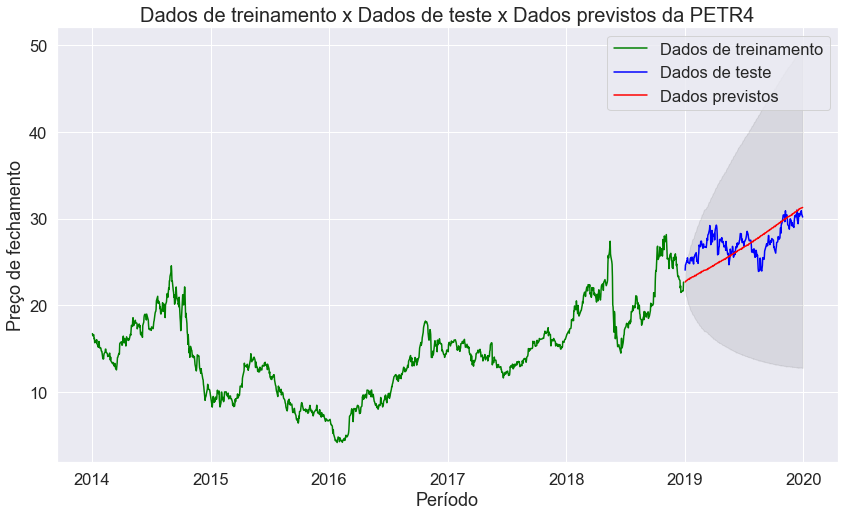

In [62]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da PETR4')
plt.plot(train_petr4_arima['Close'], color='green', label = 'Dados de treinamento')
plt.plot(test_petr4_arima['Close'], color = 'blue', label = 'Dados de teste')
plt.fill_between(test_petr4_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

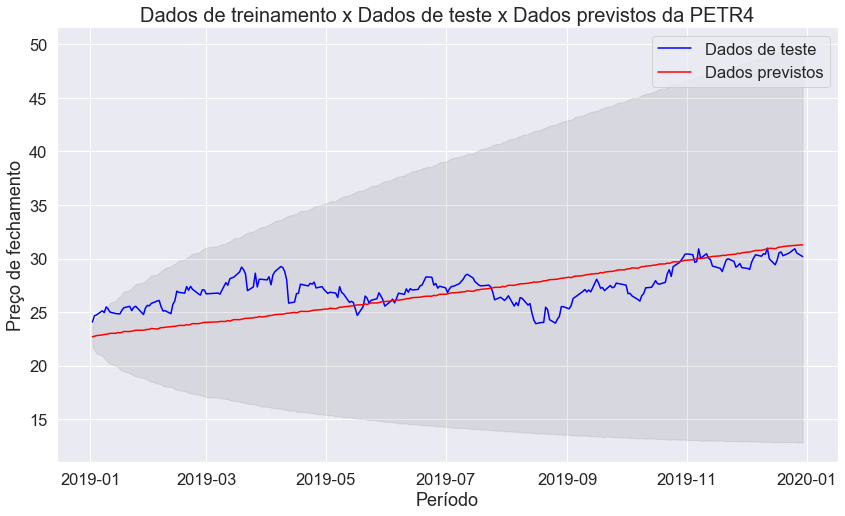

In [63]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da PETR4')
plt.plot(test_petr4_arima['Close'], color = 'blue', label = 'Dados de teste')
plt.fill_between(test_petr4_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
#plt.savefig('arima2.pdf')
plt.show()

In [64]:
#Cálculo do erro
mse = mean_squared_error(test_petr4_arima['Close'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_petr4_arima['Close'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_petr4_arima['Close'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 4.227223941642828
MAE: 1.7053041928041581
RMSE: 2.05602138647506


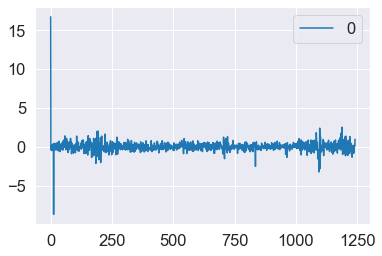

In [65]:
#Plotagem dos resíduos
residuals = pd.DataFrame(model.resid())
residuals.plot()

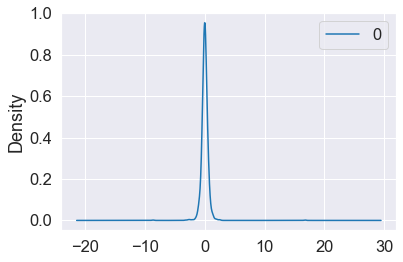

                 0
count  1242.000000
mean      0.007794
std       0.731230
min      -8.705718
25%      -0.254956
50%      -0.005407
75%       0.254053
max      16.749522


In [66]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

<h3>Modelo preditivo com RNN com arquitetura LSTM (Long Short Term Memory)</h3>

In [67]:
#Carregamento dos dados
train_petr4_lstm = train_dataset_petr4
train_petr4_lstm = train_petr4_lstm.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
test_petr4_lstm = test_dataset_petr4
test_petr4_lstm = test_petr4_lstm.drop(['Adj Close','Open','Low','High','Volume'], axis=1)

In [68]:
train_petr4_lstm.head()

,Close
Date,
2014-01-02,16.750000
2014-01-03,16.500000
2014-01-06,16.620001
2014-01-07,16.160000
2014-01-08,16.190001


In [69]:
#Normalização dos dados
train_lstm = train_petr4_lstm.iloc[:,0:1].values# seleciona o preço de fechamento
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 
train_scaled_lstm

array([[0.52378966],
       [0.5133556 ],
       [0.51836398],
       ...,
       [0.72954927],
       [0.7291319 ],
       [0.7712855 ]])

In [70]:
#Criação de uma estrutura de dados com 60 timesteps e 1 saída que neste caso será o preço de fechamento da ação
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) #Utilização de 60 timesteps anteriores
    y_train_lstm.append(train_scaled_lstm[i, 0]) #O 120º preço de fechamento será o valor de y
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [71]:
#Reshaping o dataset de treinamento 
#Sendo o segundo parâmetro como: 
       #x_train_lstm.shape[0] = batch_size, que é o número de preços de ações do período de treinamento
       #x_train_lstm.shape[1] = time_step, que é o número de preços anteriores
       #input_dim = 1, que indica que será usado o preço de fechamento
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [72]:
#Criação da LSTM utilizando a biblioteca Keras

#seed=2016
#np.random.seed (seed)

# Inicialização da RNN
model_rnn = Sequential()

#O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
#O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
#model_rnn.add(Dense(16,init='uniform',activation='relu'))
model_rnn.add(Dense(1,init='uniform',activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
1182/1182 [==============================] - 6s 5ms/step - loss: 0.0460 - mean_absolute_error: 0.1545
Epoch 2/100
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0607
Epoch 3/100
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0060 - mean_absolute_error: 0.0577
Epoch 4/100
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0048 - mean_absolute_error: 0.0517
Epoch 5/100
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0500
Epoch 6/100
1182/1182 [==============================] - 4s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0481
Epoch 7/100
1182/1182 [==============================] - 4s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0473
Epoch 8/100
1182/1182 [==============================] - 4s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0454
Epoch 9/100
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0036 - me

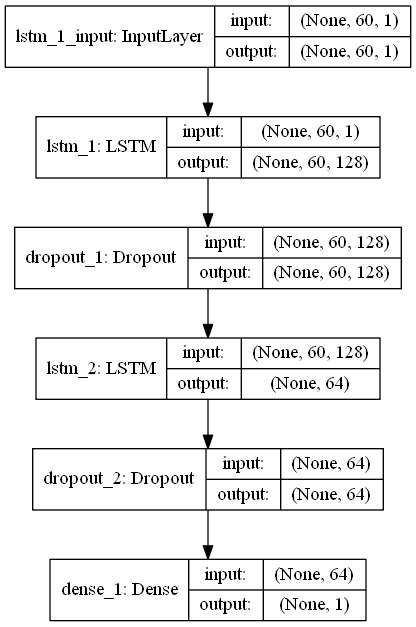

In [73]:
#Visualização do modelo
plot_model(model_rnn, show_shapes=True) #Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

In [74]:
#Carregamentos dos dados de teste para fazer as predições
test_lstm = test_petr4_lstm.iloc[:,0:1].values #seleciona o preço de fechamento

In [75]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((train_petr4_lstm['Close'], test_petr4_lstm['Close']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(test_petr4_lstm) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [76]:
# Predição utilizando os dados de teste
x_test_lstm = []
for i in range(timesteps, test_petr4_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

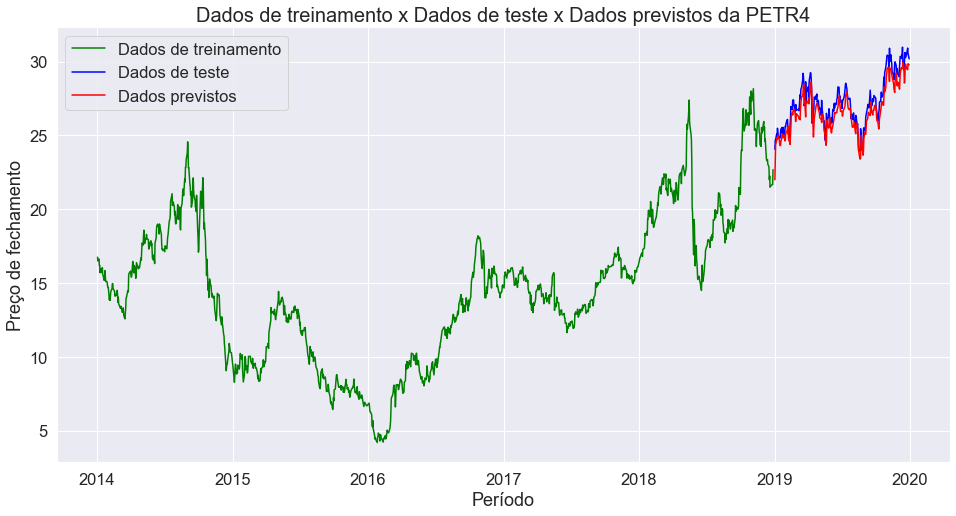

In [77]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(train_petr4_lstm.index, train_petr4_lstm, color='green', label = 'Dados de treinamento')
plt.plot(test_petr4_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(test_petr4_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos da PETR4')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
#plt.savefig('lstm1.pdf')
plt.show()

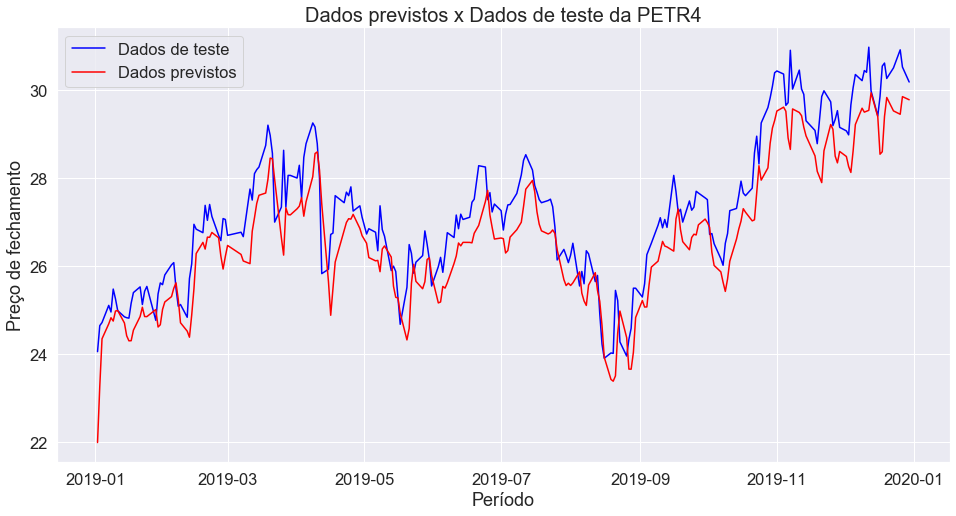

In [78]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(test_petr4_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(test_petr4_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste da PETR4')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

In [79]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(test_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(test_lstm,predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(test_lstm,predictions_lstm)))

MAE:  0.7126203606485838
MSE:  0.7135903958605112
RMSE:  0.8447427986437713


<h3>Modelo LSTM treinado utilizado nos dados futuros</h3>

In [80]:
#Teste do modelo treinado para os dados dos meses de Janeiro-Fevereiro-Março/2020
future_test_petr4_lstm =  data.DataReader(tickers[0], 'yahoo', '2020-01-01', '2020-03-31')
future_test_petr4_lstm = future_test_petr4_lstm.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
future_test_petr4_lstm.head()

,Close
Date,
2020-01-02,30.700001
2020-01-03,30.450001
2020-01-06,30.809999
2020-01-07,30.690001
2020-01-08,30.500000


In [81]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((test_petr4_lstm[-timesteps:]['Close'], future_test_petr4_lstm['Close']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(future_test_petr4_lstm['Close']) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [82]:
# Predição utilizando os dados de teste futuro
x_test_lstm = []
for i in range(timesteps, future_test_petr4_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

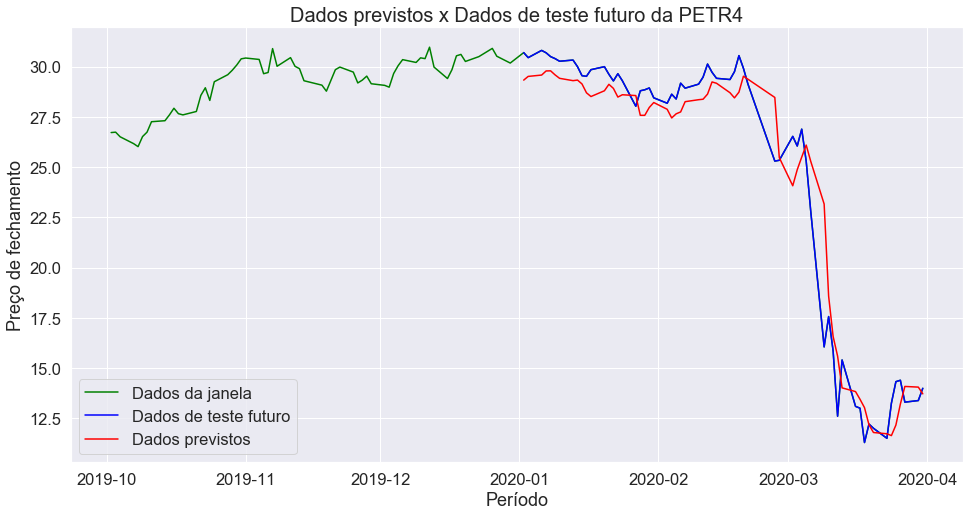

In [83]:
#Plotagem dos dados da janela, dados de teste futuro e dados previstos
plt.figure(figsize=(16,8))
plt.plot(combine.index, combine.values, color = 'green', label = 'Dados da janela')
plt.plot(future_test_petr4_lstm.index, future_test_petr4_lstm, color = 'blue', label = 'Dados de teste futuro')
plt.plot(future_test_petr4_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste futuro da PETR4')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
#plt.savefig('lstm3.pdf')
plt.show()

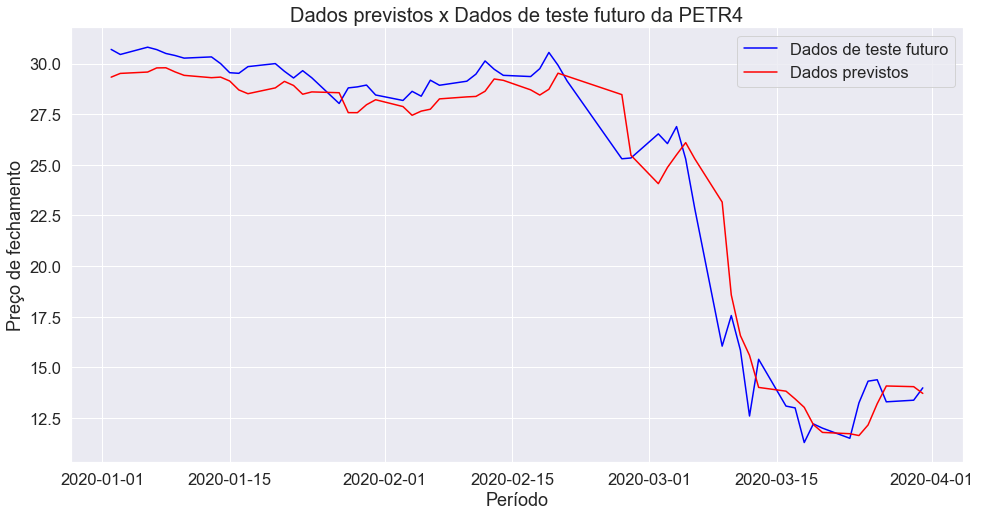

In [84]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(future_test_petr4_lstm.index, future_test_petr4_lstm, color = 'blue', label = 'Dados de teste futuro')
plt.plot(future_test_petr4_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste futuro da PETR4')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
#plt.savefig('lstm4.pdf')
plt.show()

In [85]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(future_test_petr4_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(future_test_petr4_lstm,predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(future_test_petr4_lstm,predictions_lstm)))

MAE:  1.0977982849371237
MSE:  2.2379808122853873
RMSE:  1.4959882393539687
